### Recurrent Neural Networks

A structured NN model that trains on sequential data. This is data where one sample depends on its previous sample, like in a time series (video where each image is a sequence of the previous image, stock price, audio, text)

In [1]:
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

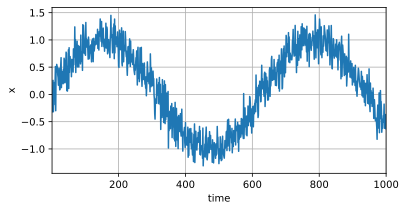

In [ ]:
# Example syntehtic data

class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2     # 0.01 frequency sin wave with 0.2 gaussian noise

data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [ ]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]     # sliding kernel of size tau to create features where each feature only depends on tau past values
    self.features = torch.stack(features, 1)
    self.labels = self.x[self.tau:].reshape((-1, 1))                        # labels are the next value after the tau past values
    i = slice(0, self.num_train) if train else slice(self.num_train, None)  # train: samples 0 - num_train         validation: samples num_train - T
    return self.get_tensorloader([self.features, self.labels], train, i)

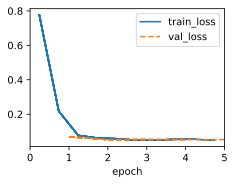

In [ ]:
model = d2l.LinearRegression(lr=0.01)                                       # uses a OLS linear reg to predict next value as weighted sums of past tau values
trainer = d2l.Trainer(max_epochs=5)                                         # output = w1 * x[t] + w2 * x[t-1] ... + w_tau * x[t-tau]
trainer.fit(model, data)                                                    # output assumed to be x[t+1] 

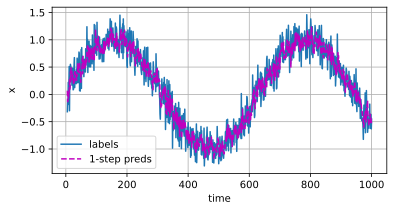

In [5]:
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))

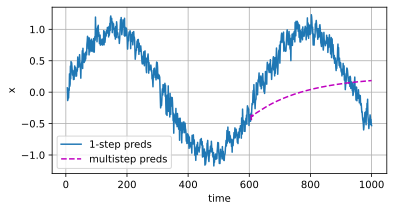

In [6]:
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))

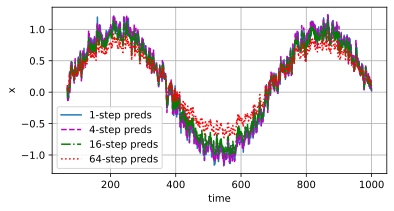

In [7]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(torch.stack(features[i : i+data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))